In [9]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# I. Chargement des données :

In [10]:
df_jeux_up = pd.read_csv("../data/details_clean.csv")

In [11]:
df_avis_up = pd.read_csv("../data/avis_clean.csv")

# II. Clustering des catégories d'un jeu :

L'attribut `categories` d'un jeu est une suite de catégories séparées par des '|'

In [12]:
jeux_cat = df_jeux_up.apply(traitement.extract_categories, axis=1)

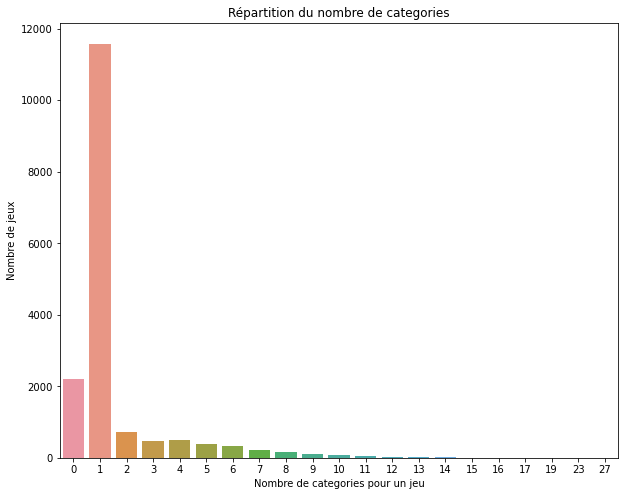

In [13]:
val, count = np.unique(jeux_cat.map(len), return_counts=True)
index = count.argsort()[::-1]
count = count[index]
val = val[index]

plt.figure(figsize=(10, 8))
sns.barplot(val, count)
plt.xlabel("Nombre de categories pour un jeu")
plt.ylabel("Nombre de jeux")
plt.title("Répartition du nombre de categories")
plt.show()

In [14]:
count[val == 0].sum() / len(jeux_cat)

0.13026729093818526

In [15]:
count[val == 1].sum() / len(jeux_cat)

0.6863628281870444

In [16]:
count[val > 1].sum() / len(jeux_cat)

0.18336988087477035

- Les majorités des jeux ont qu'une seule catégorie (68% des jeux), et environ 13% de jeux n'ont pas de catégories. 
- 18% ont plus d'une catégorie.

Avoir plusieurs catégories pour un jeu peut être dérangeant, pour des problèmes de classification entre autres.

In [17]:
cats = []
jeux_cat.map(cats.extend)
u_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
u_cats     = u_cats[index]

In [18]:
print(f"{len(u_cats)} tag de categories")

184 tag de categories


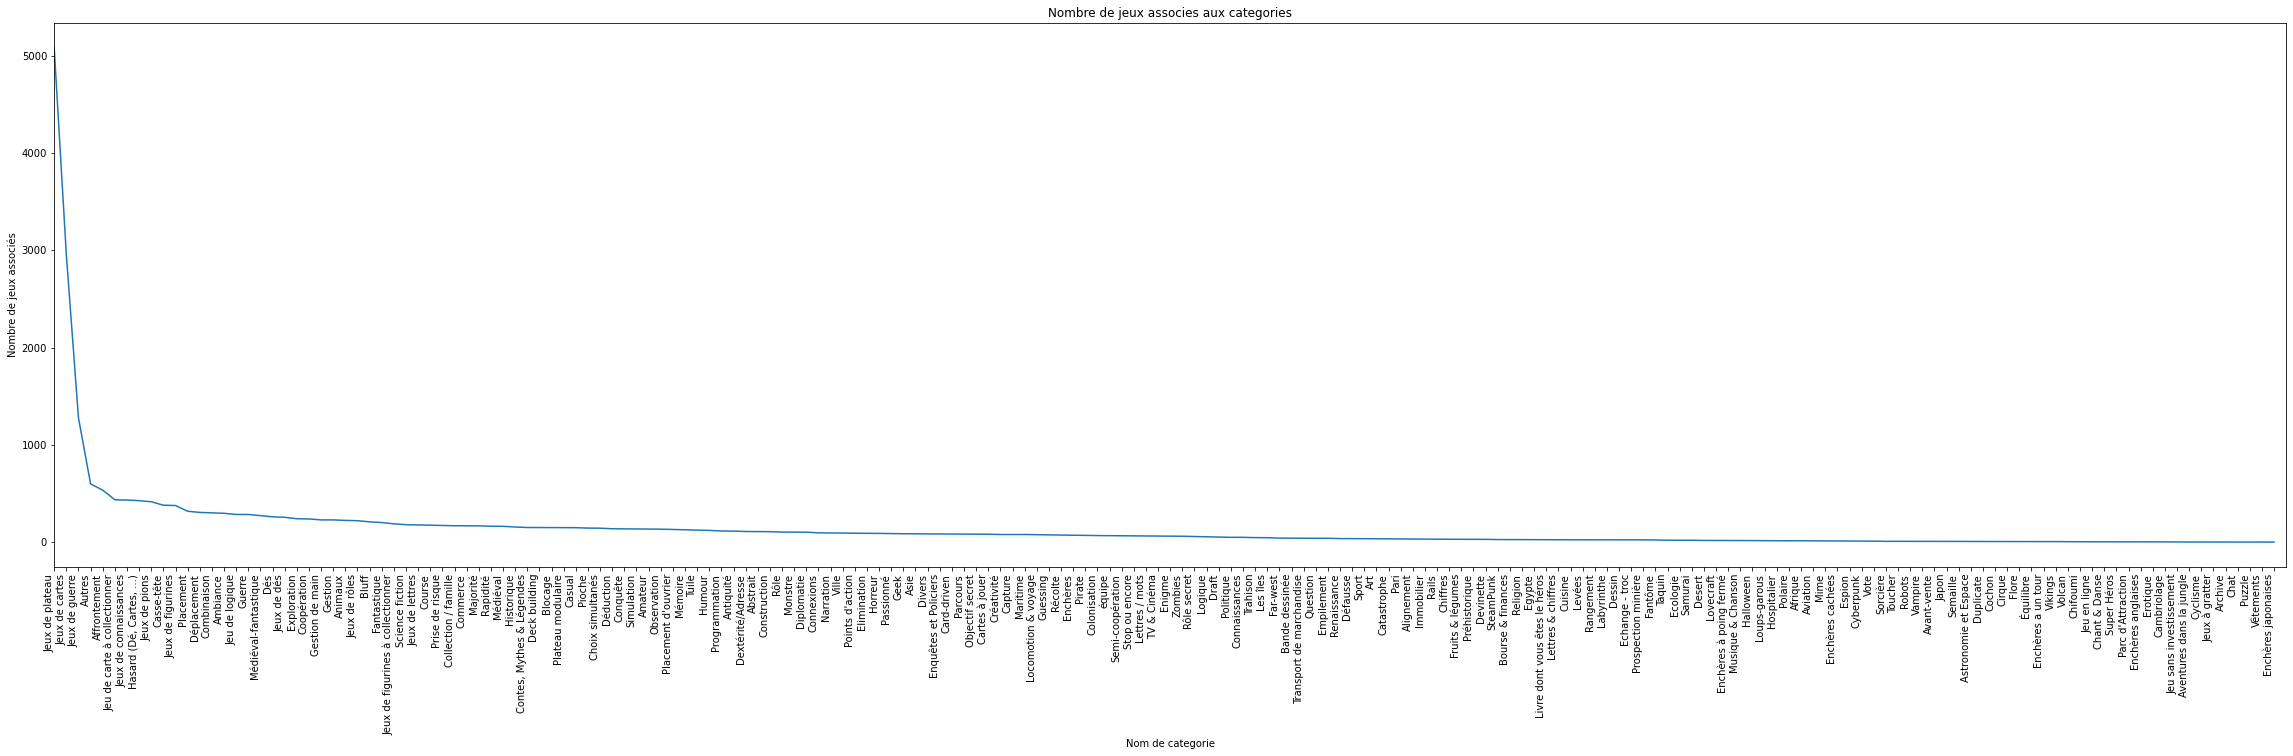

In [19]:
plt.figure(figsize=(40, 10))
plt.plot(u_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(u_cats)))
plt.show()

### 1. Nettoyer les catégories : 

In [20]:
c_cats = []

for cat in u_cats:
    cat_ = preprocessing.clean_text(cat)
    cat_tokens = preprocessing.tokenize_text(cat_)    
    cat_tokens = preprocessing.remove_stopwords(cat_tokens)
    cat_tokens = preprocessing.lemmatize_tokens(cat_tokens)
    cat_ = " ".join(cat_tokens)
    c_cats.append(cat_)

#### Mise à jour des categories des jeux

In [21]:
jeux_cat_up = jeux_cat.copy()

for i, row in jeux_cat.iteritems():
    row_ = []
    
    for cat in row:
        index = np.where(u_cats == cat)[0][0]
        row_.append(c_cats[index])
        
    jeux_cat_up[i] = np.unique(row_)

#### Supprimer la catégorie `autre` :

In [22]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 599


In [23]:
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("autre").__ne__, l))))
jeux_cat_up = jeux_cat_up.map(lambda l : np.array(list(filter(("").__ne__, l))))

In [24]:
print("Nombre de jeux ayant autre comme catégorie :", np.where(jeux_cat_up.map(lambda l : "autre" in l), 1, 0).sum())

Nombre de jeux ayant autre comme catégorie : 0


In [25]:
cats = []
jeux_cat_up.map(cats.extend)

uc_cats, count_cats = np.unique(cats, return_counts=True)

index      = count_cats.argsort()[::-1]
count_cats = count_cats[index]
uc_cats    = uc_cats[index]

In [26]:
print(f"Apres nettoyage on a {len(uc_cats)} tag de categorie")

Apres nettoyage on a 172 tag de categorie


### 2. Clustering des categories : 

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(uc_cats)
n_clusters = 155

In [46]:
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", random_state=0)
kmeans.fit(X)

for i in range(n_clusters):
    print(f"Cluster {i}:")
    for category in np.array(uc_cats)[kmeans.labels_ == i]:
        print(f"\t{category}")

Cluster 0:
	transport marchandise
	puzzle
Cluster 1:
	carte
	dé
	hasard dé carte
Cluster 2:
	fantome
Cluster 3:
	gestion
	gestion main
Cluster 4:
	cambriolage
Cluster 5:
	enchere
	enchere poing ferme
	enchere cachee
	enchere tour
	enchere anglais
	enchere japonais
Cluster 6:
	placement
	placement ouvrier
Cluster 7:
	chiffre
	lettre chiffre
Cluster 8:
	plateau
	plateau modulaire
Cluster 9:
	parc attraction
Cluster 10:
	dessin
Cluster 11:
	devinette
Cluster 12:
	sorciere
Cluster 13:
	exploration
Cluster 14:
	enquete policier
Cluster 15:
	erotiqu
Cluster 16:
	horreur
Cluster 17:
	livre hero
	super hero
Cluster 18:
	parcours
Cluster 19:
	question
Cluster 20:
	role
Cluster 21:
	vetement
Cluster 22:
	loup garou
Cluster 23:
	medieval fantastique
	fantastique
	medieval
Cluster 24:
	conte mythe legende
Cluster 25:
	cyclisme
Cluster 26:
	lettre
	lettre mot
Cluster 27:
	equipe
Cluster 28:
	steampunk
Cluster 29:
	mime
Cluster 30:
	bluff
Cluster 31:
	diplomati
Cluster 32:
	historique
Cluster 33:
	r

In [29]:
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", random_state=0)
kmeans.fit(X)

for i in range(n_clusters):
    L_clus = []
    
    for category in np.array(uc_cats)[kmeans.labels_ == i]:
        L_clus.extend(category.split(" "))
        
    noms, counts = np.unique(np.array(L_clus), return_counts=True)
    index = counts.argsort()[::-1]
    counts = counts[index]
    noms   = noms[index]   
    print(" ".join(noms[counts == counts[0]]))
    # TODO : reaffecter les labels au cats
        

transport puzzle marchandise
dé carte
fantome
gestion
cambriolage
enchere
placement
chiffre
plateau
parc attraction
dessin
devinette
sorciere
exploration
policier enquete
erotiqu
horreur
hero
parcours
question
role
vetement
loup garou
medieval fantastique
mythe legende conte
cyclisme
lettre
equipe
steampunk
mime
bluff
diplomati
historique
rangement
logique
afrique
defausse
chat
programmation
deck building
vote
taquin
dexterite adresse
rapidite
duplicate
animal
ville
deduction
conquete
simulation
passionner
guessing
famille collection
connexion
monstre
geek
driven card
objectif
tete casser
pirate
affrontement
tuile
pion
maritime
casual
cooperation
halloween
memoire
cochon
combinaison
immobilier
religion
aviation
volcan
vampire
chifoumi
observation
zombie
majorite
gratter
asie
amateur
robot
troc echange
dessinee bande
science fiction
vente
espace astronomie
catastrophe
legume fruit
figurine
creativite
equilibre
musique chanson
recolte
toucher
espion
samurai
polaire
labyrinthe
lovecraft
h

# TODO :

- base de données pour regrouper tous ce qui est pays : afrique, asie, egypte ....
- et aussi pour les animaux (cochon animal ...)
- Et aussi monstre (zombie monstre vampire ...)

### 3. Sélection des N catégories principales : 

On va pondérer les catégories par leur log proba d'apparition pour estimer leur importance, et ainsi sélectionner que les principales.

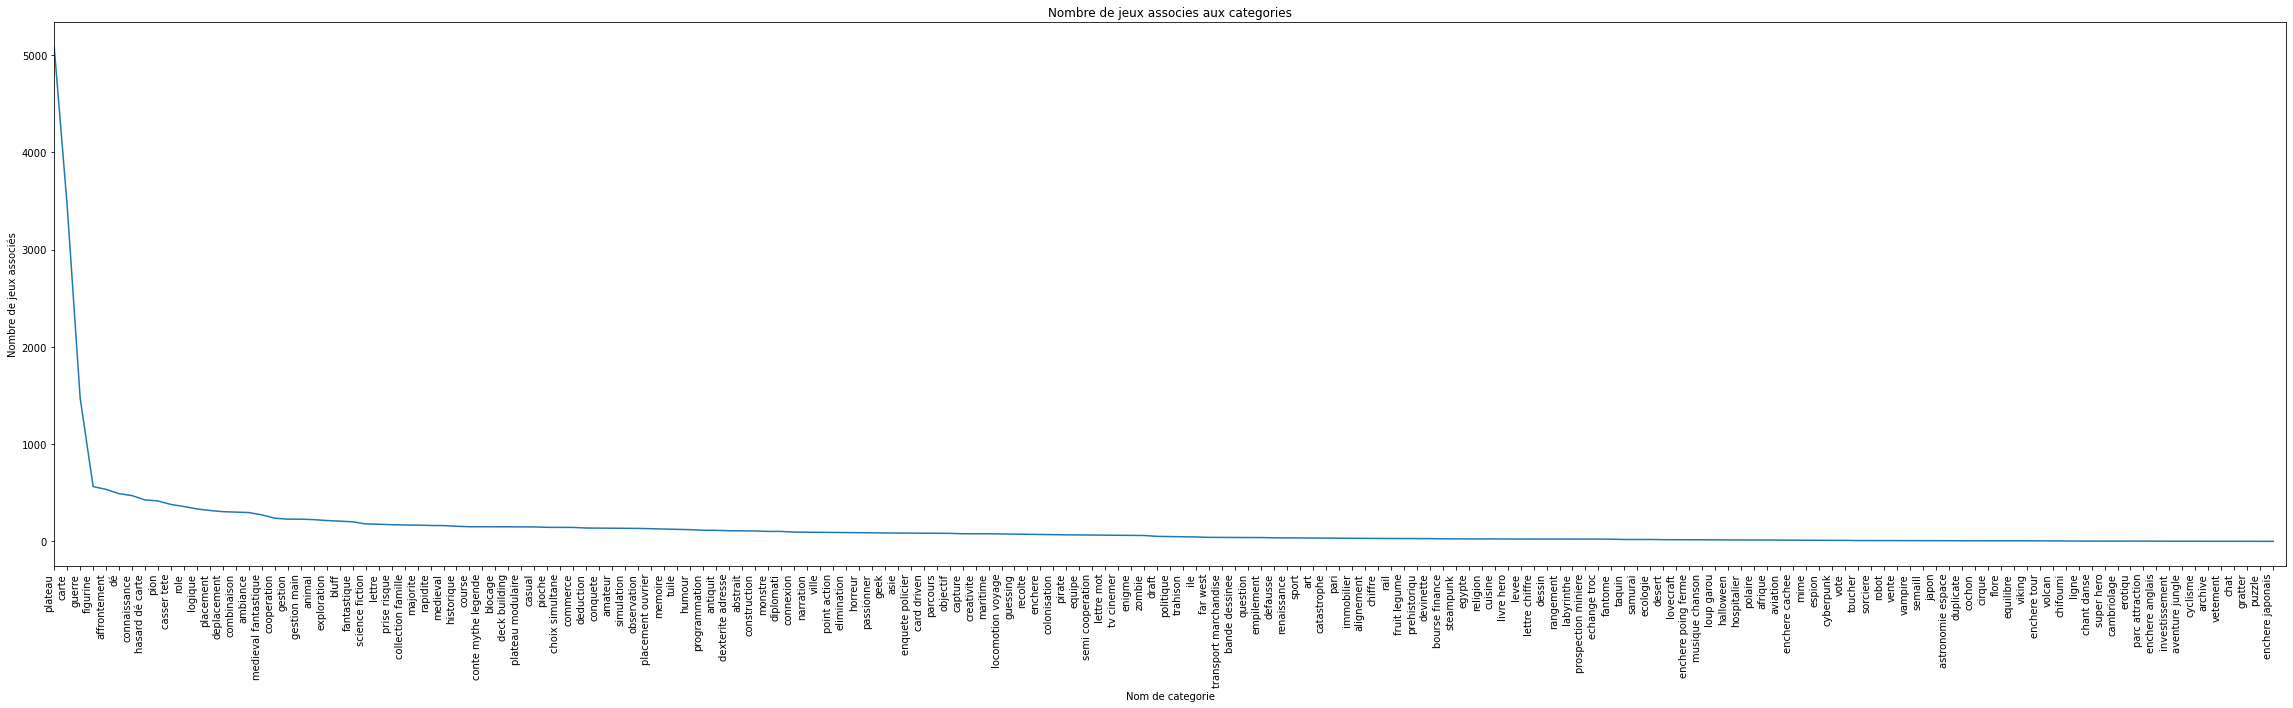

In [30]:
plt.figure(figsize=(40, 10))
plt.plot(uc_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(uc_cats)))
plt.show()

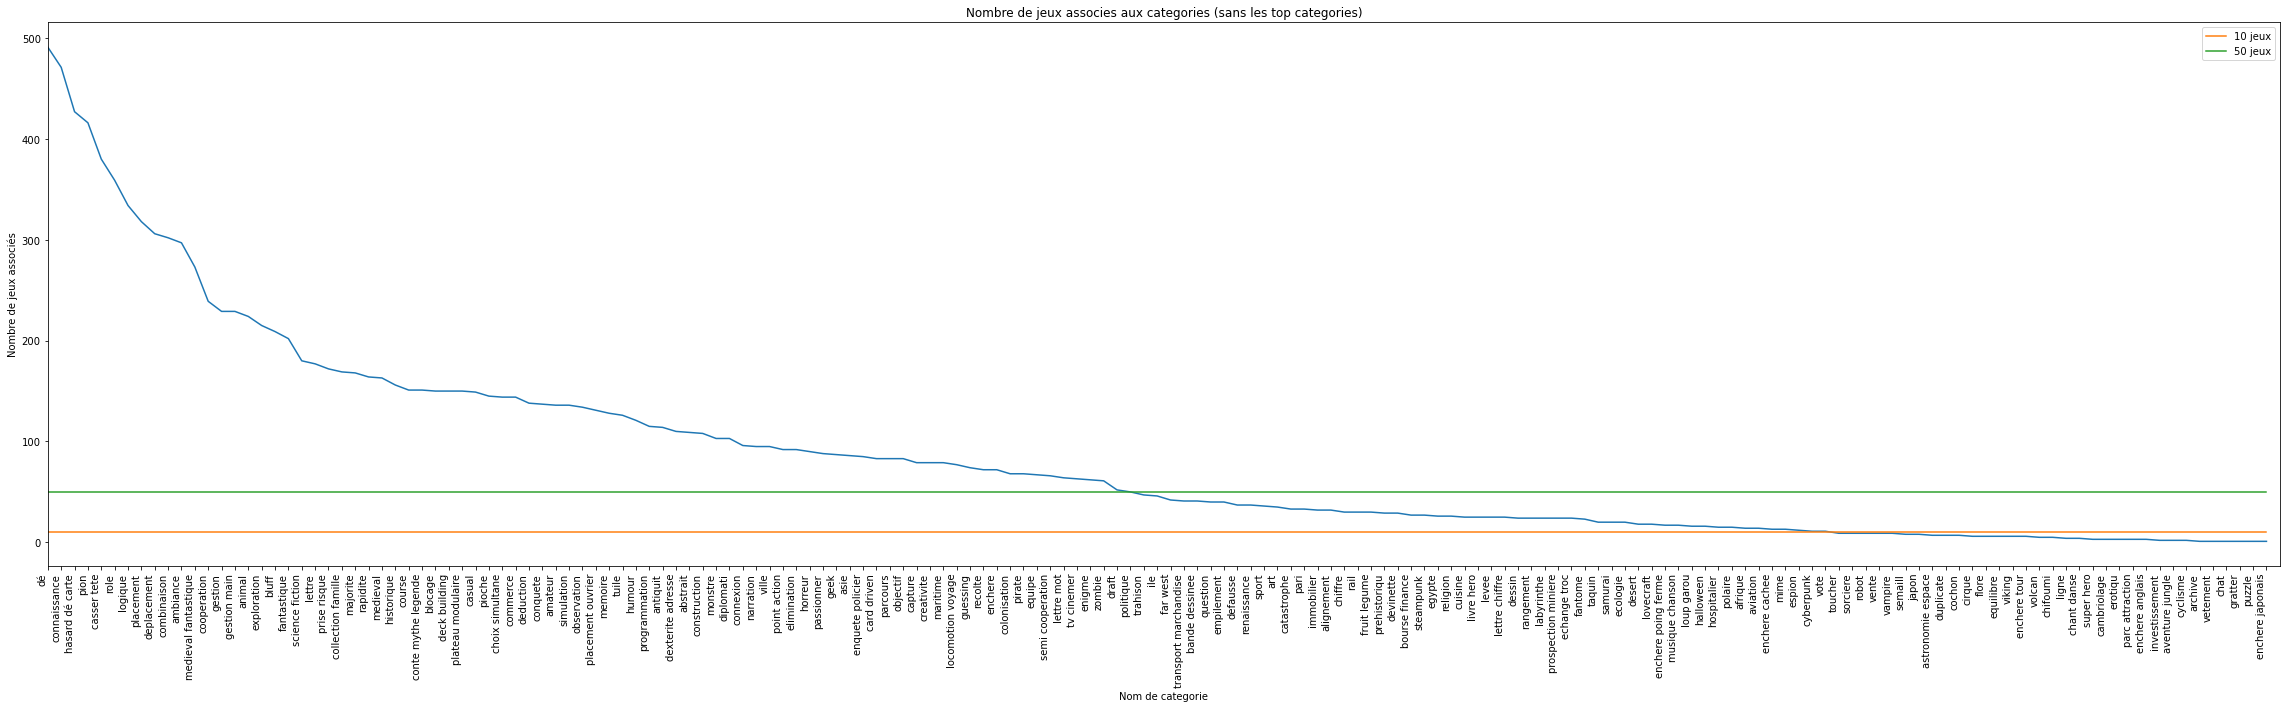

In [31]:
index = count_cats < 500
plt.figure(figsize=(40, 10))
plt.plot(uc_cats[index], count_cats[index])
plt.plot(np.full(len(uc_cats[index]), 10), label="10 jeux")
plt.plot(np.full(len(uc_cats[index]), 50), label="50 jeux")
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories (sans les top categories)")
plt.xlim((0, len(uc_cats[index])))
plt.legend()
plt.show()

In [32]:
p_C_J = []
jeux_cat_up.map(lambda l : np.isin(uc_cats, l).astype(int).tolist()).map(p_C_J.append)
p_C_J = np.array(p_C_J)
p_C_J = p_C_J / p_C_J.sum()
p_C_J.shape

(16873, 172)

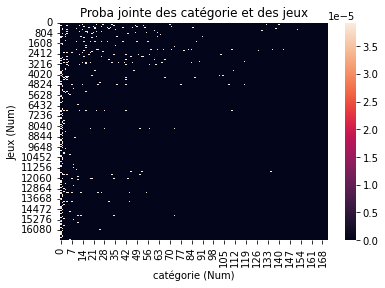

In [33]:
sns.heatmap(p_C_J)
plt.xlabel("catégorie (Num)")
plt.ylabel("Jeux (Num)")
plt.title('Proba jointe des catégorie et des jeux')
plt.show()

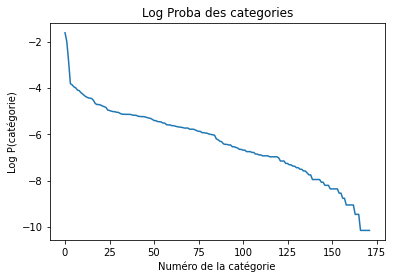

In [34]:
p_cat = p_C_J.sum(axis=0) 
plt.plot(np.log(p_cat))
plt.xlabel("Numéro de la catégorie")
plt.ylabel("Log P(catégorie)")
plt.title("Log Proba des categories")
plt.show()

In [35]:
I = []
jeux_cat_up.map(lambda l : (np.isin(uc_cats, l).astype(int) / (len(l) if len(l) != 0 else 1)).tolist()).map(I.append)
I = np.array(I)
I.shape

(16873, 172)

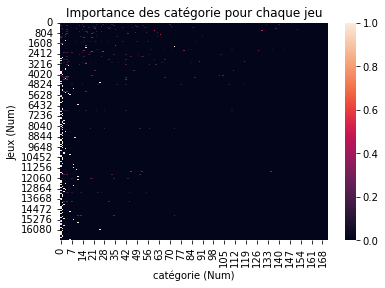

In [36]:
sns.heatmap(I)
plt.xlabel("catégorie (Num)")
plt.ylabel("Jeux (Num)")
plt.title('Importance des catégorie pour chaque jeu')
plt.show()

Soit I une mesure d'importance donné sous cette forme :

$$I(cat_i) = \frac{\sum_j\frac{Q_j(cat_i)}{\lvert L_j \rvert}}{{\sum_j Q_j(cat_i)}} \ \ avec \ Q_j(cat_i) = 1 \ si \ cat_i \in L_j$$

In [37]:
Q = []
jeux_cat_up.map(lambda l : np.isin(uc_cats, l).astype(int).tolist()).map(Q.append)
Q = np.array(Q)
Q = Q.sum(axis=0)
Q

array([5081, 3451, 1476,  564,  535,  491,  471,  427,  416,  380,  359,
        334,  318,  306,  302,  297,  273,  239,  229,  229,  224,  215,
        209,  202,  180,  177,  172,  169,  168,  164,  163,  156,  151,
        151,  150,  150,  150,  149,  145,  144,  144,  138,  137,  136,
        136,  134,  131,  128,  126,  121,  115,  114,  110,  109,  108,
        103,  103,   96,   95,   95,   92,   92,   90,   88,   87,   86,
         85,   83,   83,   83,   79,   79,   79,   77,   74,   72,   72,
         68,   68,   67,   66,   64,   63,   62,   61,   52,   50,   47,
         46,   42,   41,   41,   40,   40,   37,   37,   36,   35,   33,
         33,   32,   32,   30,   30,   30,   29,   29,   27,   27,   26,
         26,   25,   25,   25,   25,   24,   24,   24,   24,   24,   23,
         20,   20,   20,   18,   18,   17,   17,   16,   16,   15,   15,
         14,   14,   13,   13,   12,   11,   11,    9,    9,    9,    9,
          9,    8,    8,    7,    7,    7,    6,   

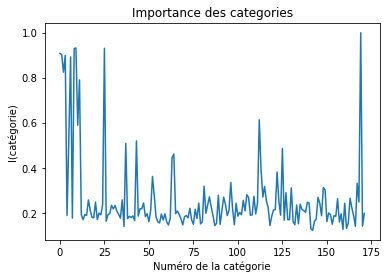

In [38]:
I_cat = I.sum(axis=0) / Q
plt.plot(I_cat)
plt.xlabel("Numéro de la catégorie")
plt.ylabel("I(catégorie)")
plt.title("Importance des categories")
plt.show()

In [39]:
jeux_cat_up_I = jeux_cat_up.copy()
l_uc_cats = list(uc_cats)

for j, row in jeux_cat_up.iteritems():
        
    if len(row) == 0:
        continue
        
    I_j = np.zeros(len(l_uc_cats))
    for cat in row:
        i = l_uc_cats.index(cat)
#         I_j[i] = I_cat[i]
        I_j[i] = Q[i]
        
    i_max = np.argmax(I_j)
    jeux_cat_up_I[j] = [l_uc_cats[i_max]]

In [40]:
cats = []
jeux_cat_up_I.map(cats.extend)

one_uc_cats, count_cats = np.unique(cats, return_counts=True)

index       = count_cats.argsort()[::-1]
count_cats  = count_cats[index]
one_uc_cats = one_uc_cats[index]

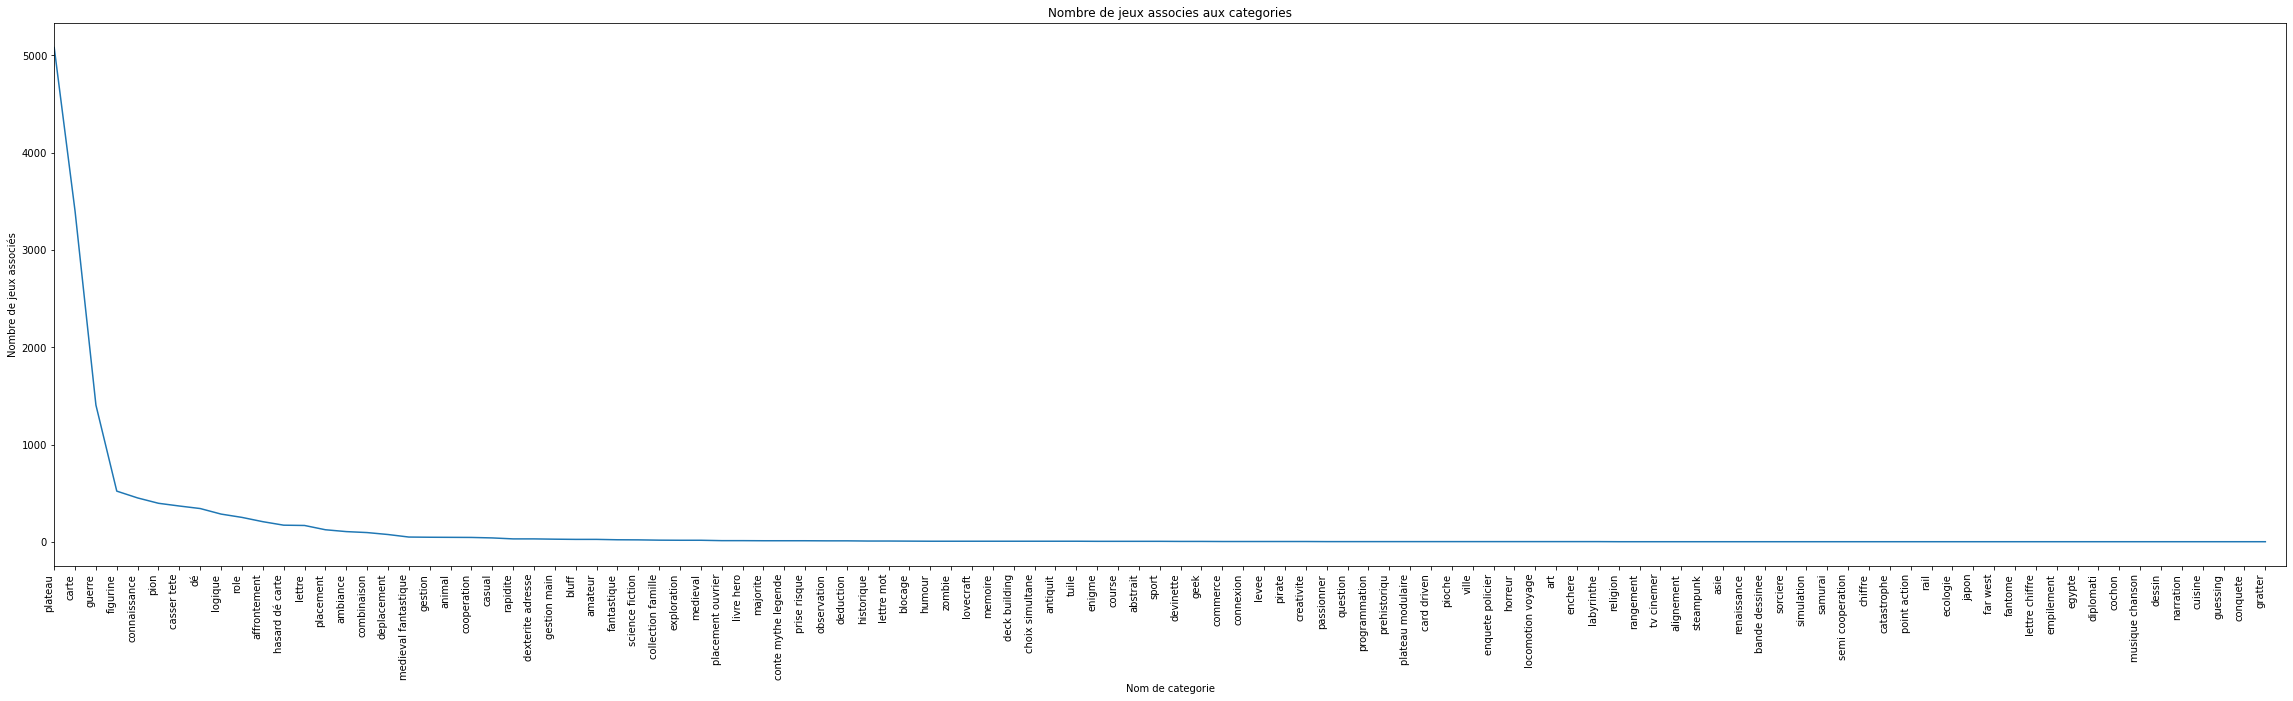

In [41]:
plt.figure(figsize=(40, 10))
plt.plot(one_uc_cats, count_cats)
plt.xticks(rotation=90, ha='right')
plt.xlabel("Nom de categorie")
plt.ylabel("Nombre de jeux associés")
plt.title("Nombre de jeux associes aux categories")
plt.xlim((0, len(one_uc_cats)))
plt.show()

In [42]:
set(uc_cats) - set(one_uc_cats)

{'afrique',
 'archive',
 'astronomie espace',
 'aventure jungle',
 'aviation',
 'bourse finance',
 'cambriolage',
 'capture',
 'chant danse',
 'chat',
 'chifoumi',
 'cirque',
 'colonisation',
 'construction',
 'cyberpunk',
 'cyclisme',
 'defausse',
 'desert',
 'draft',
 'duplicate',
 'echange troc',
 'elimination',
 'enchere anglais',
 'enchere cachee',
 'enchere japonais',
 'enchere poing ferme',
 'enchere tour',
 'equilibre',
 'equipe',
 'erotiqu',
 'espion',
 'flore',
 'fruit legume',
 'halloween',
 'hospitalier',
 'ile',
 'immobilier',
 'investissement',
 'ligne',
 'loup garou',
 'maritime',
 'mime',
 'monstre',
 'objectif',
 'parc attraction',
 'parcours',
 'pari',
 'polaire',
 'politique',
 'prospection miniere',
 'puzzle',
 'recolte',
 'robot',
 'semaill',
 'super hero',
 'taquin',
 'toucher',
 'trahison',
 'transport marchandise',
 'vampire',
 'vente',
 'vetement',
 'viking',
 'volcan',
 'vote'}

### TODO : Seuillage ? pour séléctionner les N (remplacer les drop par `autre`)

## Résultat intéressant ! TODO

- Ajouter quelques mots dans le sw pour affiner et sélectionner les catégories les plus importantes pourrait vraiment donner de (très) bons résultats.